In [1]:
import tensorflow as tf
tf.__version__

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


'1.4.0'

In [3]:
from tensorflow.contrib import keras
from keras import backend as K
from keras.applications.imagenet_utils import preprocess_input, decode_predictions
import numpy as np
import time
import os

np.random.seed(1337)

Using TensorFlow backend.


In [4]:
from keras.models import Sequential
from keras.layers import Convolution2D, MaxPooling2D
from keras.layers.core import Dense, Dropout, Flatten
from keras.preprocessing.image import ImageDataGenerator
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils
from keras import backend as K
from numpy import nan
import sys
import datetime

now = datetime.datetime.now

In [5]:
from matplotlib import pyplot as plt

%matplotlib inline

In [9]:
from keras.applications import vgg16
from keras.layers import Input

# Builds the VGG-16 model with ImageNet weights.
vgg16 = vgg16.VGG16(weights='imagenet', include_top=False, input_tensor=Input((224, 224, 3)))
print('Model loaded.')

Model loaded.


As is, the weights in the model were obtained by training the model
on hundreds of thousands of images. We're using the top of this model 
as a feature extractor. 
In this next step we set these layers as 'not trainable'. This prevents 
the randomly initialized Dense layers we're going to add in a little bit 
from ruining them during the first few epochs.

In [11]:
for l in vgg16.layers:
    l.trainable = False

In [13]:
vgg16.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [12]:
from keras import regularizers

x = Flatten(input_shape=vgg16.output.shape)(vgg16.output)
x = Dense(4096, activation='relu', name='fully_connected_1')(x)
x = Dropout(0.3)(x)
x = Dense(4096, activation='relu', name='fully_connected_2')(x)
x = Dropout(0.4)(x)
x = Dense(2048, activation='relu', name='fully_connected_3')(x)
x = Dropout(0.5)(x)

x = BatchNormalization()(x)
predictions = Dense(4, activation = 'softmax')(x)

In [13]:
from keras.models import Model

model = Model(inputs=vgg16.input, outputs=predictions)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [14]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [15]:
train_1_datagen = ImageDataGenerator(
        zoom_range=0.2,
        rotation_range = 20,
        horizontal_flip=True,
        vertical_flip=True)
train_1_generator = train_1_datagen.flow_from_directory(
        '../data/train_o2_1',
        target_size=(224, 224),
        batch_size=32, 
        class_mode='categorical')

Found 2016 images belonging to 4 classes.


In [16]:
train_2_datagen = ImageDataGenerator(
        zoom_range=0.2,
        rotation_range = 20,
        horizontal_flip=True,
        vertical_flip=True)
train_2_generator = train_2_datagen.flow_from_directory(
        '../data/train_o2_2',
        target_size=(224, 224),
        batch_size=32, 
        class_mode='categorical')

Found 4033 images belonging to 4 classes.


In [17]:
validation_datagen = ImageDataGenerator()

In [18]:
validation_generator = validation_datagen.flow_from_directory(
        '../data/validation_o2',
        target_size=(224, 224),
        batch_size=32,
        class_mode='categorical')

Found 1009 images belonging to 4 classes.


In [19]:
test_datagen = ImageDataGenerator()

In [20]:
test_generator = test_datagen.flow_from_directory(
        '../data/test_o2',
        target_size=(224,224),
        batch_size=32,
        class_mode='categorical')

Found 561 images belonging to 4 classes.


In [21]:
from keras.preprocessing import image

In [22]:
from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_acc', min_delta=0.01, patience=8, verbose=0, mode='auto')

model.fit_generator(
        train_2_generator,
        steps_per_epoch=126,
        epochs=100,
        validation_data=validation_generator,
        validation_steps=32,
        use_multiprocessing=True,
        callbacks = [early_stopping])

Epoch 1/100
127/126 [==============================] - 130s 1s/step - loss: 1.2957 - acc: 0.5055 - val_loss: 1.0695 - val_acc: 0.6482
Epoch 2/100
127/126 [==============================] - 122s 964ms/step - loss: 0.8610 - acc: 0.6673 - val_loss: 1.0605 - val_acc: 0.6105
Epoch 3/100
127/126 [==============================] - 123s 967ms/step - loss: 0.7097 - acc: 0.7337 - val_loss: 0.4703 - val_acc: 0.8147
Epoch 4/100
127/126 [==============================] - 124s 976ms/step - loss: 0.6338 - acc: 0.7668 - val_loss: 0.5006 - val_acc: 0.8147
Epoch 5/100
127/126 [==============================] - 122s 961ms/step - loss: 0.5227 - acc: 0.8081 - val_loss: 0.4811 - val_acc: 0.8285
Epoch 6/100
127/126 [==============================] - 118s 930ms/step - loss: 0.5496 - acc: 0.8032 - val_loss: 0.4668 - val_acc: 0.8315
Epoch 7/100
127/126 [==============================] - 117s 925ms/step - loss: 0.5466 - acc: 0.7972 - val_loss: 0.6357 - val_acc: 0.7849
Epoch 8/100
127/126 [=======================

In [23]:
model_history = _

In [24]:
model.evaluate_generator(validation_generator,steps=38)

[0.39794834709852728, 0.88206144703627809]

In [29]:
model.evaluate_generator(validation_generator,steps=38)

[1.8730717547703073, 0.76610505474570723]

In [26]:
import cv2
import pandas as pd
from sklearn.metrics import classification_report

t = test_generator.class_indices

In [27]:
def test_report(model,t):
    df = pd.read_csv('../data/test/xy.txt')
    y_cat = np_utils.to_categorical([t[i] for i in df.order], 4)
    iml = []
    for f,o in zip(df.file_name,df.order):
        i_path = '../data/test/{}/{}'.format(o,f)
        iml.append(cv2.resize(cv2.imread(i_path,1),(224,224),interpolation = cv2.INTER_AREA))
    iml = np.stack(iml)
    test_datagen = ImageDataGenerator()
    test_generator = test_datagen.flow(iml,y_cat, batch_size=32)
    pred = model.predict(iml)
    inv_map = {v: k for k, v in t.items()}
    y_pred = [inv_map[np.argmax(i)] for i in pred]
    y_true = [inv_map[np.argmax(i)] for i in y_cat]
    print(classification_report(y_true,y_pred))


In [28]:
test_report(model,t)

               precision    recall  f1-score   support

      Diptera       0.81      0.95      0.87       116
Ephemeroptera       0.92      0.88      0.90       104
   Plecoptera       0.93      0.80      0.86        82
  Trichoptera       0.88      0.83      0.86        78

  avg / total       0.88      0.87      0.87       380



In [31]:
model.save_weights('../data/model_weights/best_weights.h5')

In [38]:
df2 = pd.read_csv('../data/meta.txt',sep=';')

In [45]:
test_ind = np.array([np.where(df2.file_name == i)[0][0] for i in df.file_name])

In [48]:
df2.iloc[test_ind].head()

,file_name,file_path,ready,back_view,side_view,ruler,hand_nature,m_adult,contrast,noisy_background,partial,order,family
39,photo_553054.jpg,../data/bug_guide/plecoptera/photo_553054.jpg,0,0,0,0,1,0,0,0,0,Stoneflies (Plecoptera),Rolled-winged Stoneflies (Leuctridae)
1995,photo_585610.jpg,../data/bug_guide/diptera/photo_585610.jpg,0,0,0,0,0,1,0,1,0,Flies (Diptera),Lesser Dung Flies (Sphaeroceridae)
1436,photo_9719.jpg,../data/bug_guide/diptera/photo_9719.jpg,0,0,0,0,1,1,0,0,0,Flies (Diptera),Robber Flies (Asilidae)
5048,picture4281.jpg,../data/troutnut/ephemeroptera/picture4281.jpg,1,0,0,0,0,0,0,0,0,Ephemeroptera (Mayflies),"Heptageniidae (March Browns, Cahills, Quill Go..."
2608,picture1347.jpg,../data/troutnut/diptera/picture1347.jpg,0,0,0,0,0,0,0,0,1,Diptera (True Flies),Simuliidae (Black Flies)


In [62]:
df_test = df2.iloc[test_ind]
conditions = ((df_test.ready == 1))
test_file_name = df_test.iloc[np.where(conditions)[0]].file_name
test_order = df_test.iloc[np.where(conditions)[0]].order
order_dict = {'Stoneflies (Plecoptera)':'Plecoptera','Plecoptera (Stoneflies)':'Plecoptera',
'Mayflies (Ephemeroptera)':'Ephemeroptera','Ephemeroptera (Mayflies)':'Ephemeroptera',
'Caddisflies (Trichoptera)':'Trichoptera','Trichoptera (Caddisflies)':'Trichoptera',
'Diptera (True Flies)':'Diptera','Flies (Diptera)':'Diptera'}
order_list = []
for i in test_order:
    order_list.append(order_dict[i])
test_order = order_list
y_cat = np_utils.to_categorical([t[i] for i in test_order], 4)
iml = []
for f,o in zip(test_file_name,test_order):
    i_path = '../data/test/{}/{}'.format(o,f)
    iml.append(cv2.resize(cv2.imread(i_path,1),(224,224),interpolation = cv2.INTER_AREA))
iml = np.stack(iml)
test_datagen = ImageDataGenerator()
test_generator = test_datagen.flow(iml,y_cat, batch_size=32)
pred = model.predict(iml)
inv_map = {v: k for k, v in t.items()}
y_pred = [inv_map[np.argmax(i)] for i in pred]
y_true = [inv_map[np.argmax(i)] for i in y_cat]
print(classification_report(y_true,y_pred))

               precision    recall  f1-score   support

      Diptera       0.64      0.78      0.70         9
Ephemeroptera       1.00      0.91      0.95        32
   Plecoptera       0.88      1.00      0.93         7
  Trichoptera       0.85      0.85      0.85        13

  avg / total       0.90      0.89      0.89        61



In [67]:
conflict = [i != j for i, j in zip(y_pred,y_true)]

In [72]:
y_pred = np.array(y_pred)
y_pred[conflict]
y_true = np.array(y_true)
print(y_pred[conflict],y_true[conflict])

['Plecoptera' 'Trichoptera' 'Trichoptera' 'Diptera' 'Diptera' 'Diptera'
 'Diptera'] ['Ephemeroptera' 'Diptera' 'Diptera' 'Ephemeroptera' 'Trichoptera'
 'Trichoptera' 'Ephemeroptera']


In [107]:
test_file_name[conflict]

4346      picture299.jpg
3076     picture1226.jpg
1379    photo_256002.jpg
5478     picture4303.jpg
893     photo_887192.jpg
970     photo_759208.jpg
5103     picture4155.jpg
Name: file_name, dtype: object

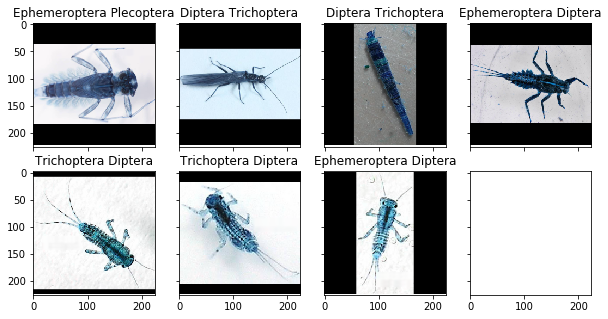

In [94]:
fig, axs = plt.subplots(2, 4, sharex=True, sharey=True, figsize = (10,5))
for img, ax,l1,l2 in zip(iml,np.ravel(axs),y_true[conflict],y_pred[conflict]):
    ax.imshow(img)
    ax.set_title((l1+" "+l2))